In [3]:
from sph import *
from tqdm.notebook import trange, tqdm
%matplotlib notebook

In [117]:
pdf = lambda x: np.sin(x * np.pi * 4) + 2
# pdf = lambda x: 1 + x
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
# def pdf(x):
#     x = np.array(x)
#     out = np.array(np.ones_like(x))
#     out[x > 0] = x[x>0] + 0
#     out[x < 0] = x[x<0] + 2
#     return out + 1

# pdf = lambda x: np.abs(x) + 1

# pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
# pdf = lambda x: np.ones_like(np.array(x))
numParticles = 2048

# noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
# noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
# pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)

In [226]:
def computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
#     fluidVelocities += xsphUpdate
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionCoefficient, fluidNeighbors, fluidRadialDistances, fluidDistances)
    # fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

<IPython.core.display.Javascript object>


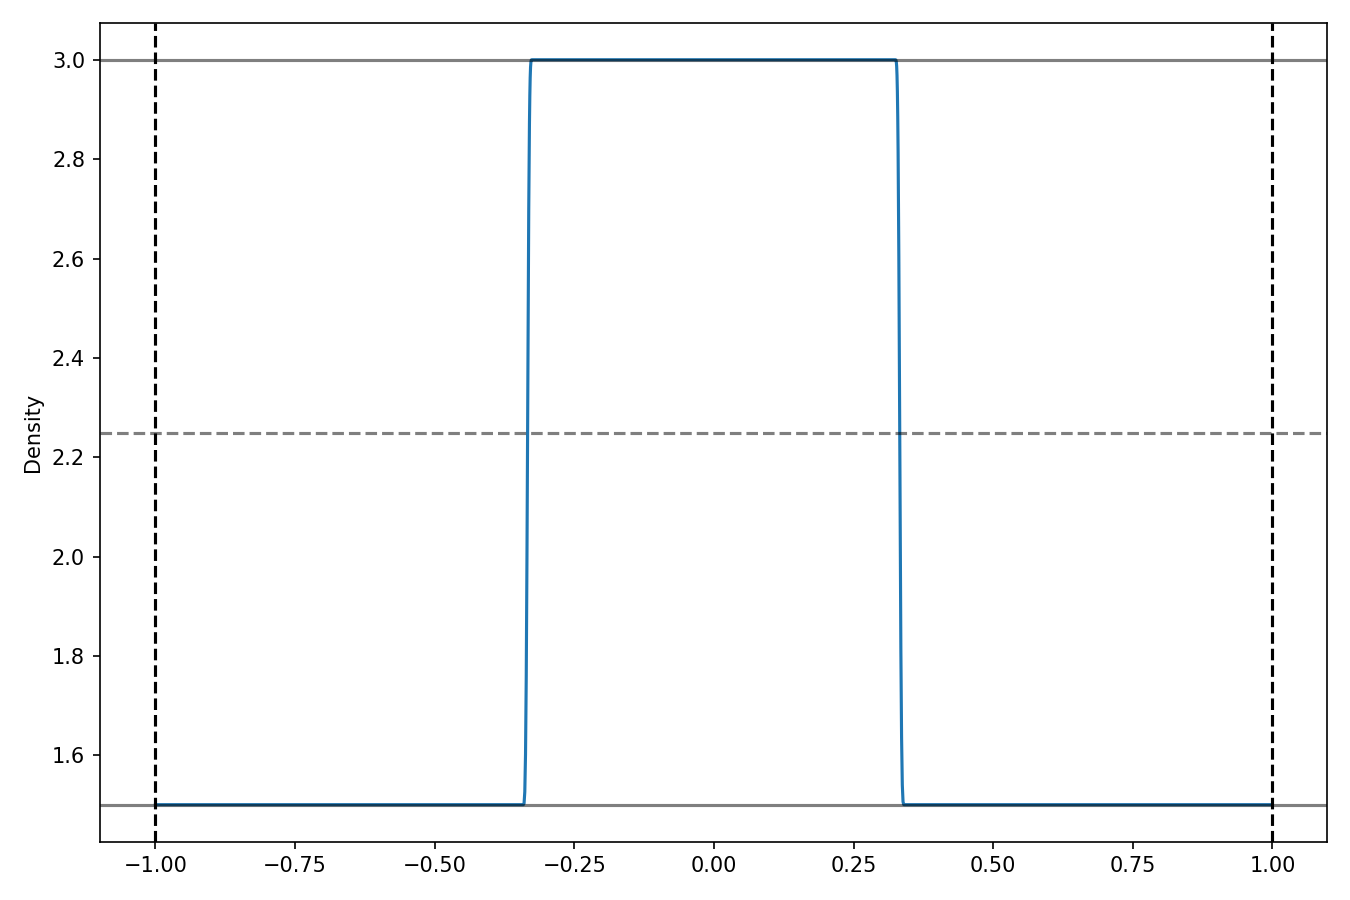

In [235]:
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
particleSupport = particleRadius * 8.
xsphConstant = 0.1
kappa = 10
restDensity = 1000
dt = 1e-3

timesteps = 2048

minDomain = -1
maxDomain = 1
c0 = 100

diffusionCoefficient = 0.


fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain)
fluidVelocities = torch.zeros(fluidPositions.shape[0])
fluidAreas = torch.ones_like(fluidPositions) * baseArea
simulationStates = []

plotDensity(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

In [236]:
for i in tqdm(range(timesteps)):
    v1 = torch.clone(fluidVelocities)
    dudt_k1, dxdt_k1, _, _ = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)    
    
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    dudt_k2, dxdt_k2, _, _ = computeUpdate(x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, 0.5 * dt)    
    
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    dudt_k3, dxdt_k3, _, _ = computeUpdate(x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport,  0.5 * dt)    
    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    dudt_k4, dxdt_k4, fluidDensity, fluidPressure = computeUpdate(x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)    
    
    
#     dudt, dxdt, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)    
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dudt, fluidAreas]))
    
#     fluidVelocities = fluidVelocities + dt* (k1 )
#     fluidPositions = fluidPositions + dt * dxdt
#     fluidVelocities = fluidVelocities + dt * dudt
#     fluidVelocities = fluidVelocities + dt * (k1 )
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
#     fluidPositions = fluidPositions + dt/6 * (dxdt_k1 + 2* dxdt_k2 + 2 * dxdt_k3 + dxdt_k4)
    
    #  8. Euler integration of velocities and positions
#     fluidVelocities += dt * dudt
#     fluidPositions += dt * fluidVelocities
    #  9. Enforce boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
    # 10. Resort data for convenience
#     indices = torch.argsort(fluidPositions)
#     fluidPositions = fluidPositions[indices]
#     fluidVelocities = fluidVelocities[indices]
#     fluidAreas = fluidAreas[indices]
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


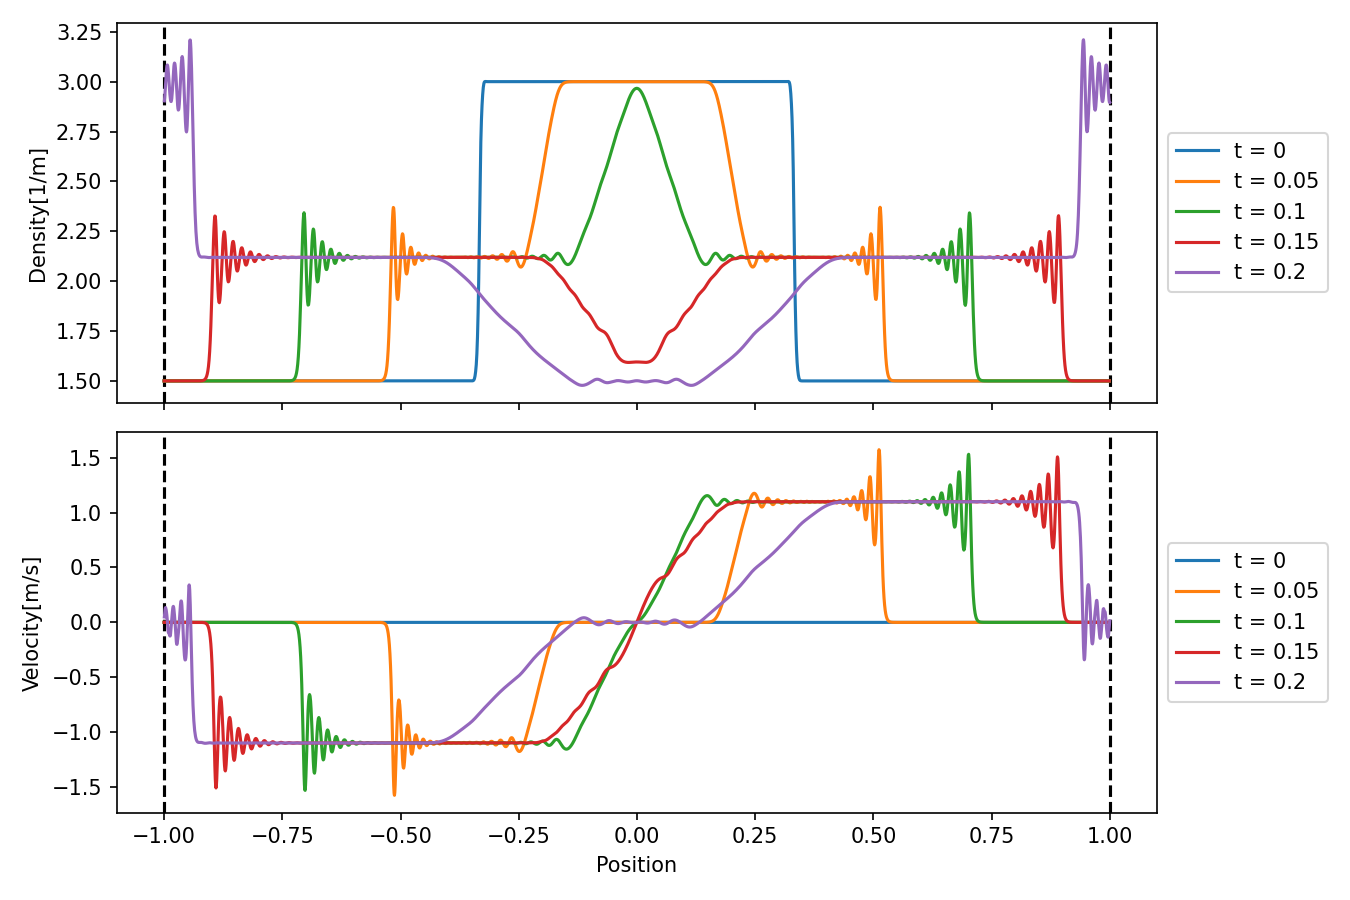

In [237]:
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 150, 200])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
# regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


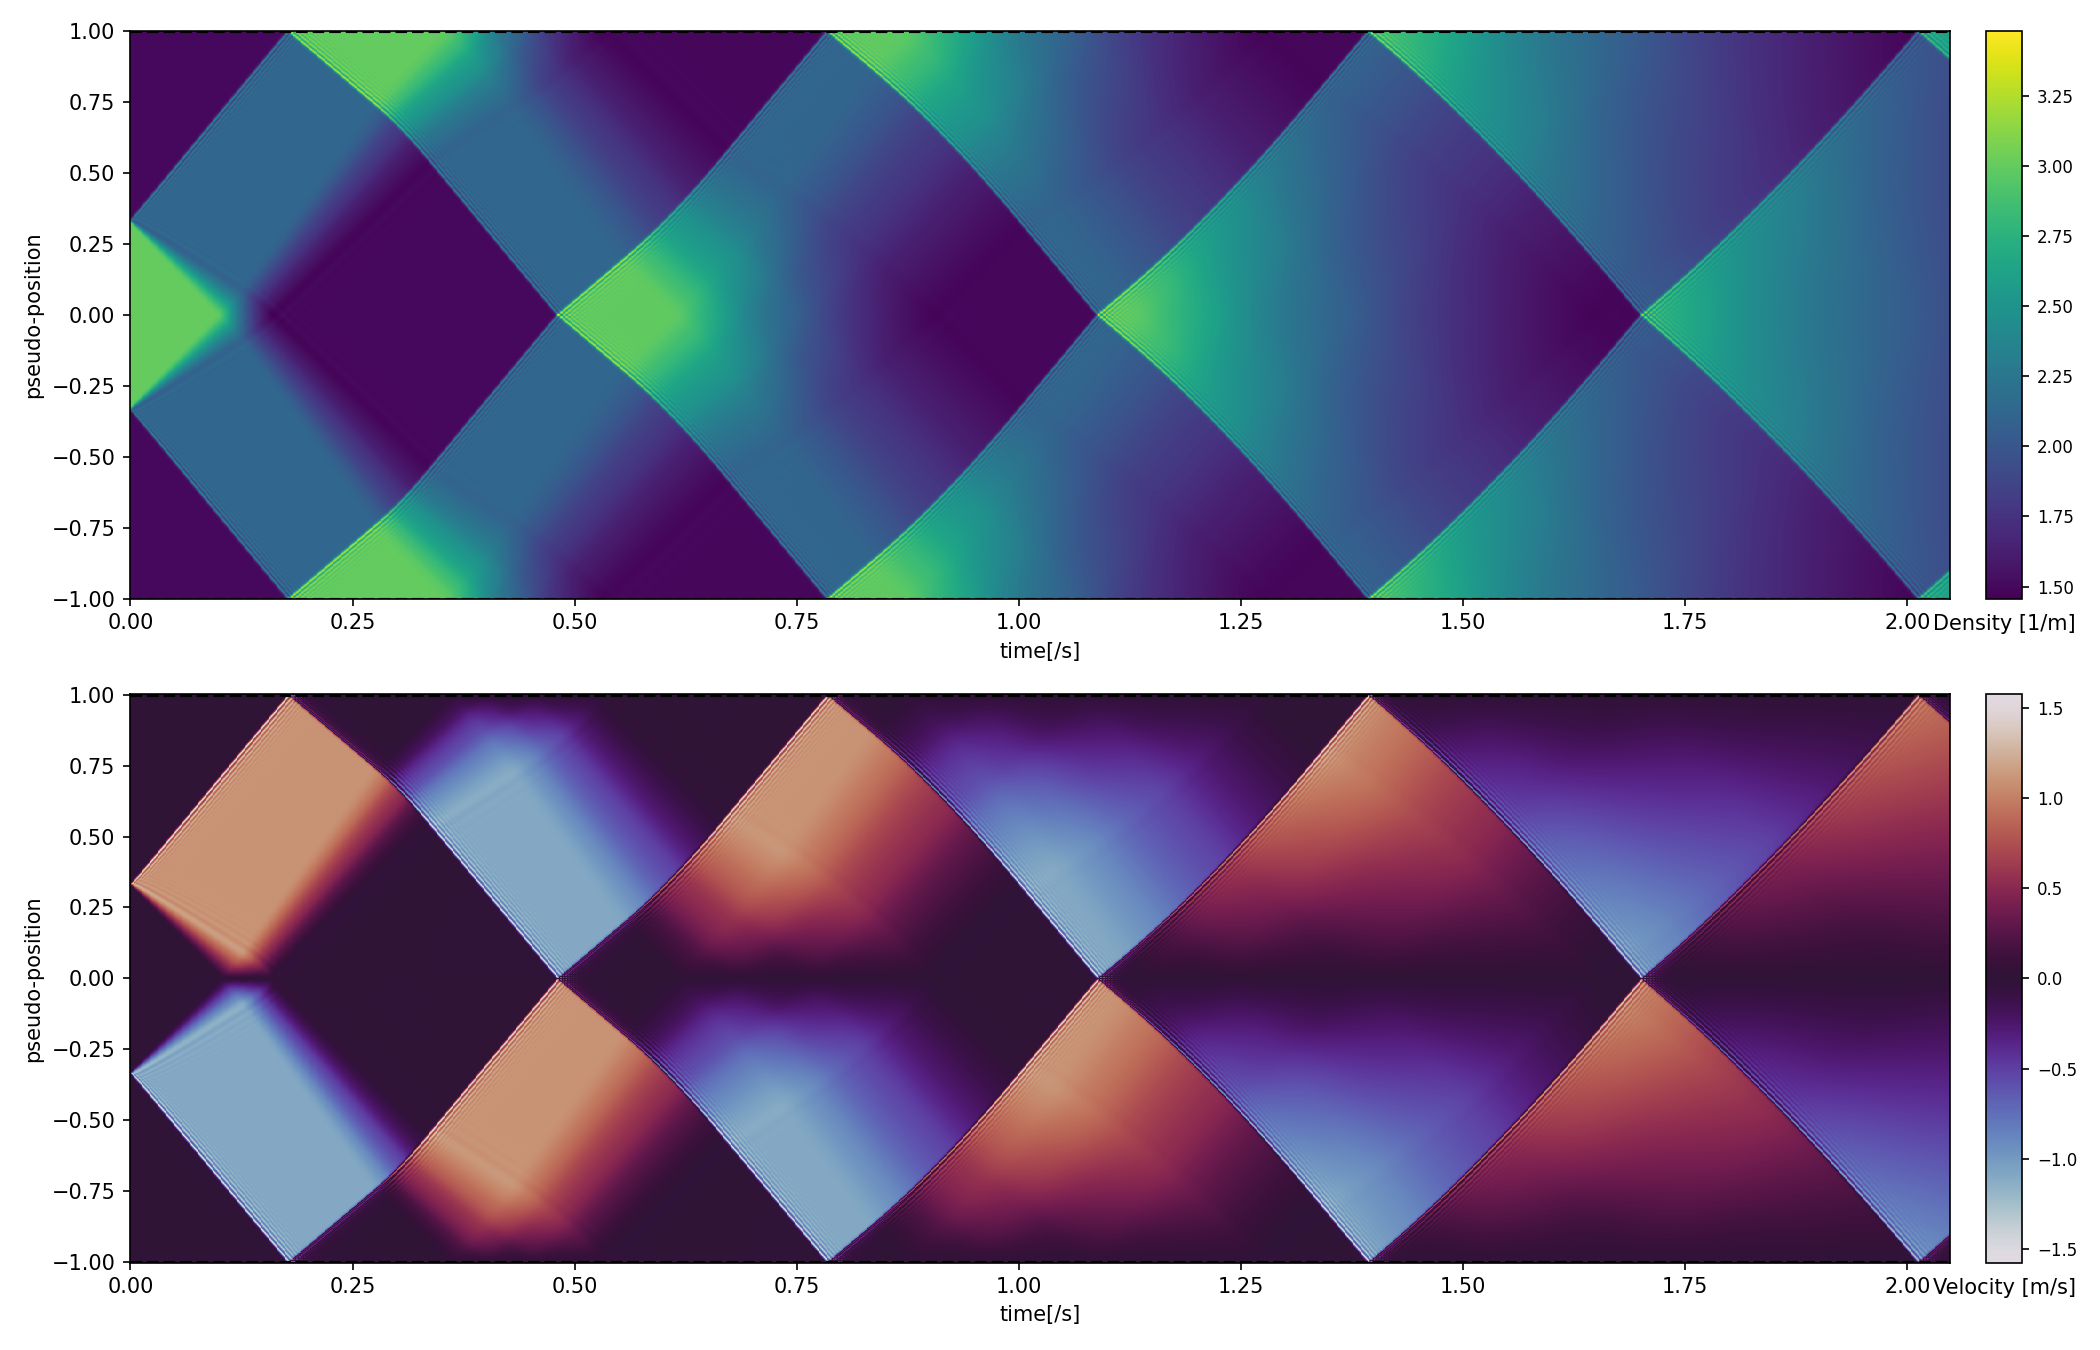

In [238]:
# plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


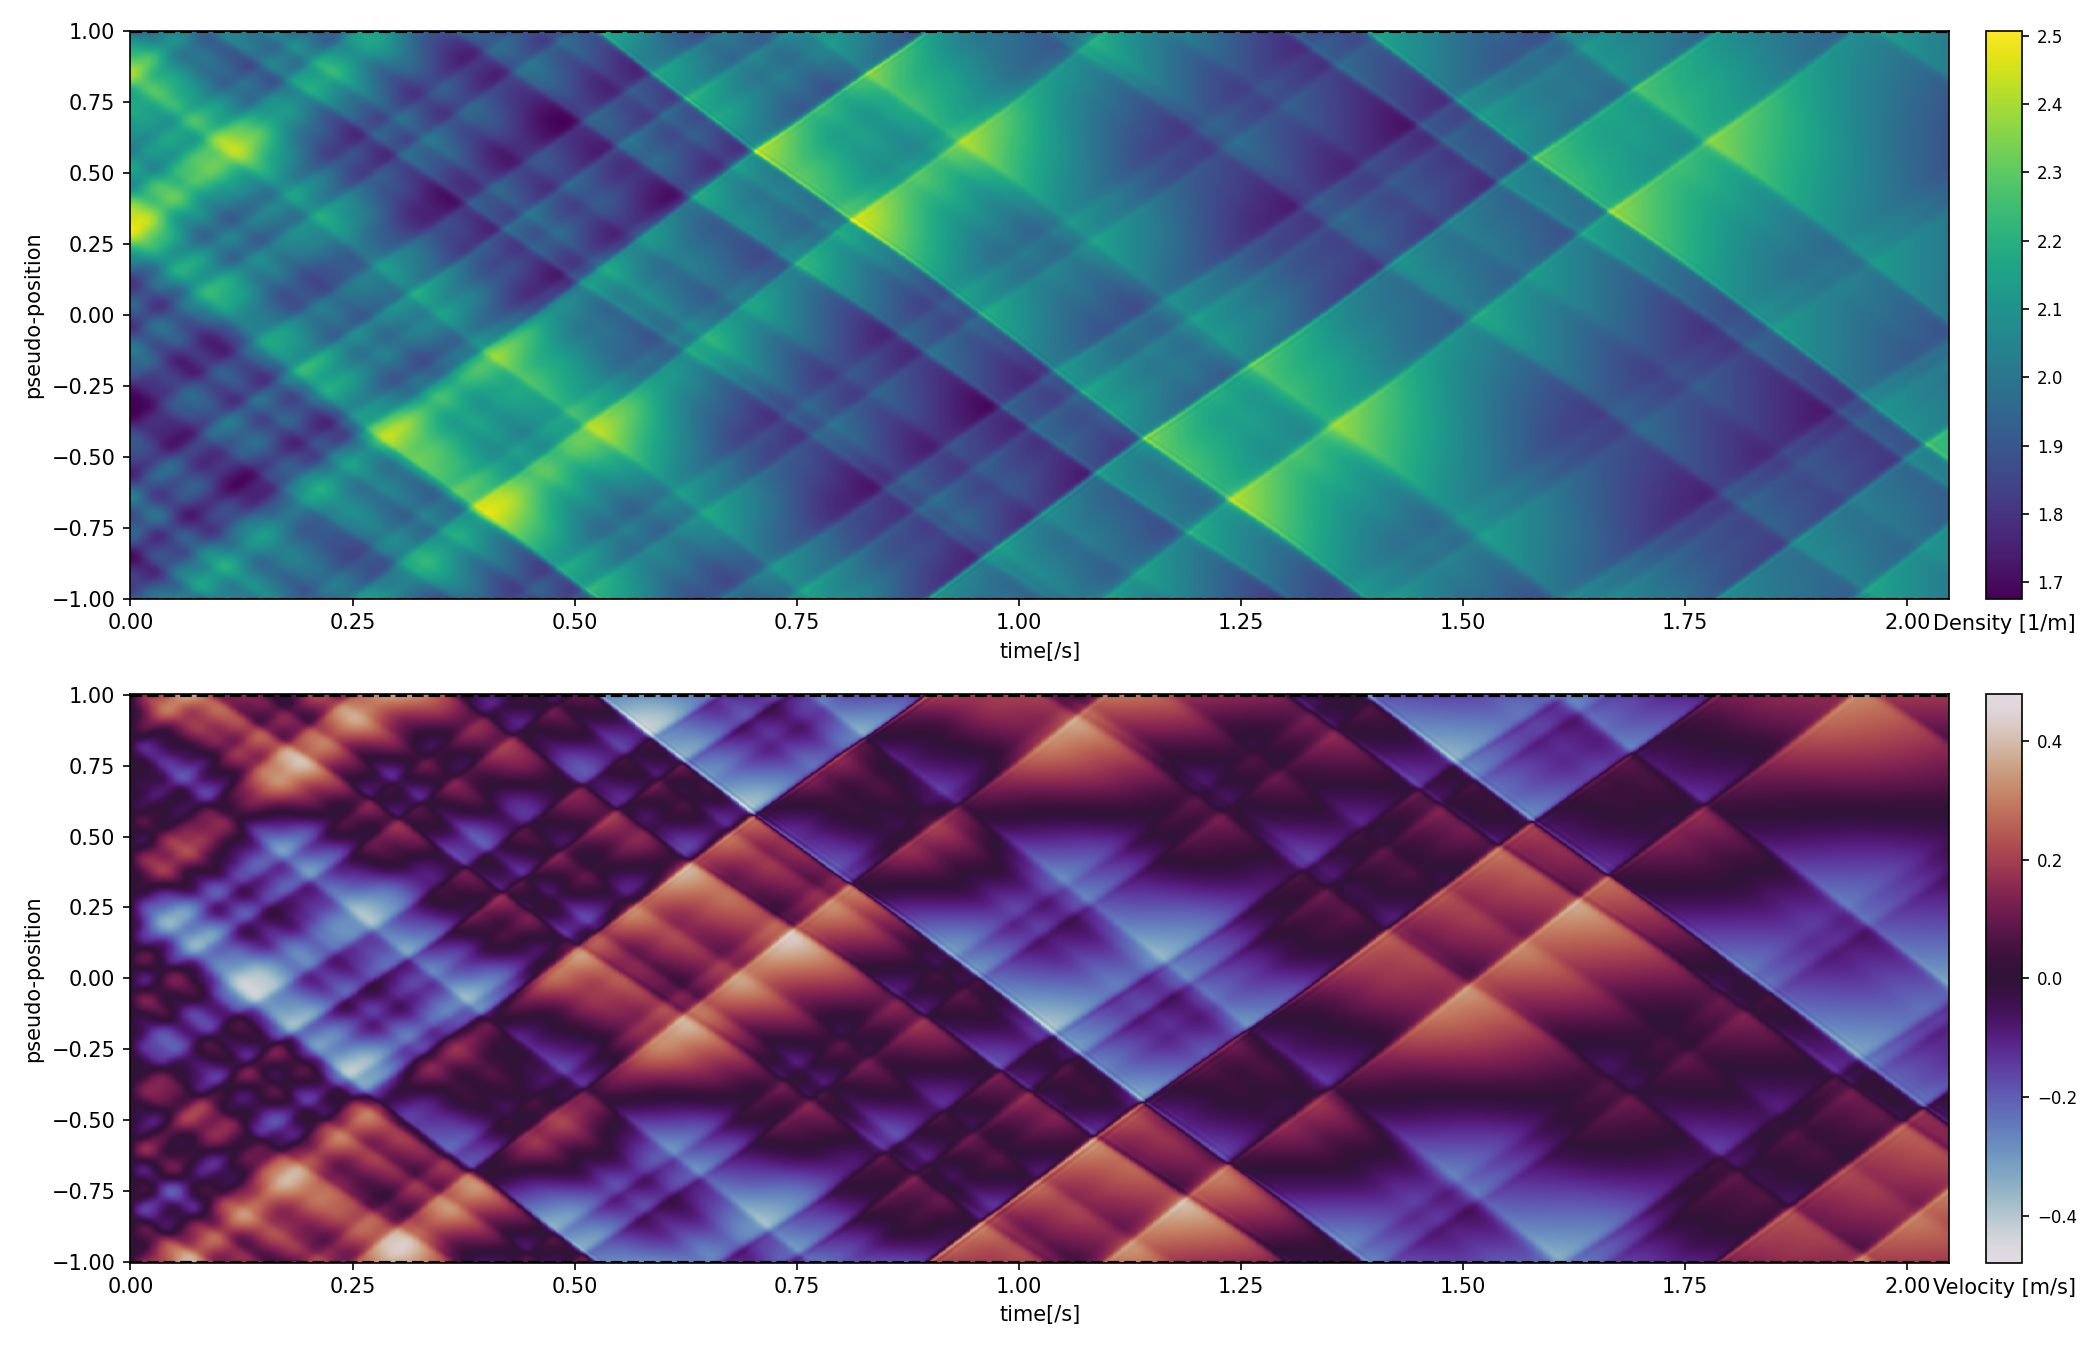

In [106]:
# plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

<IPython.core.display.Javascript object>


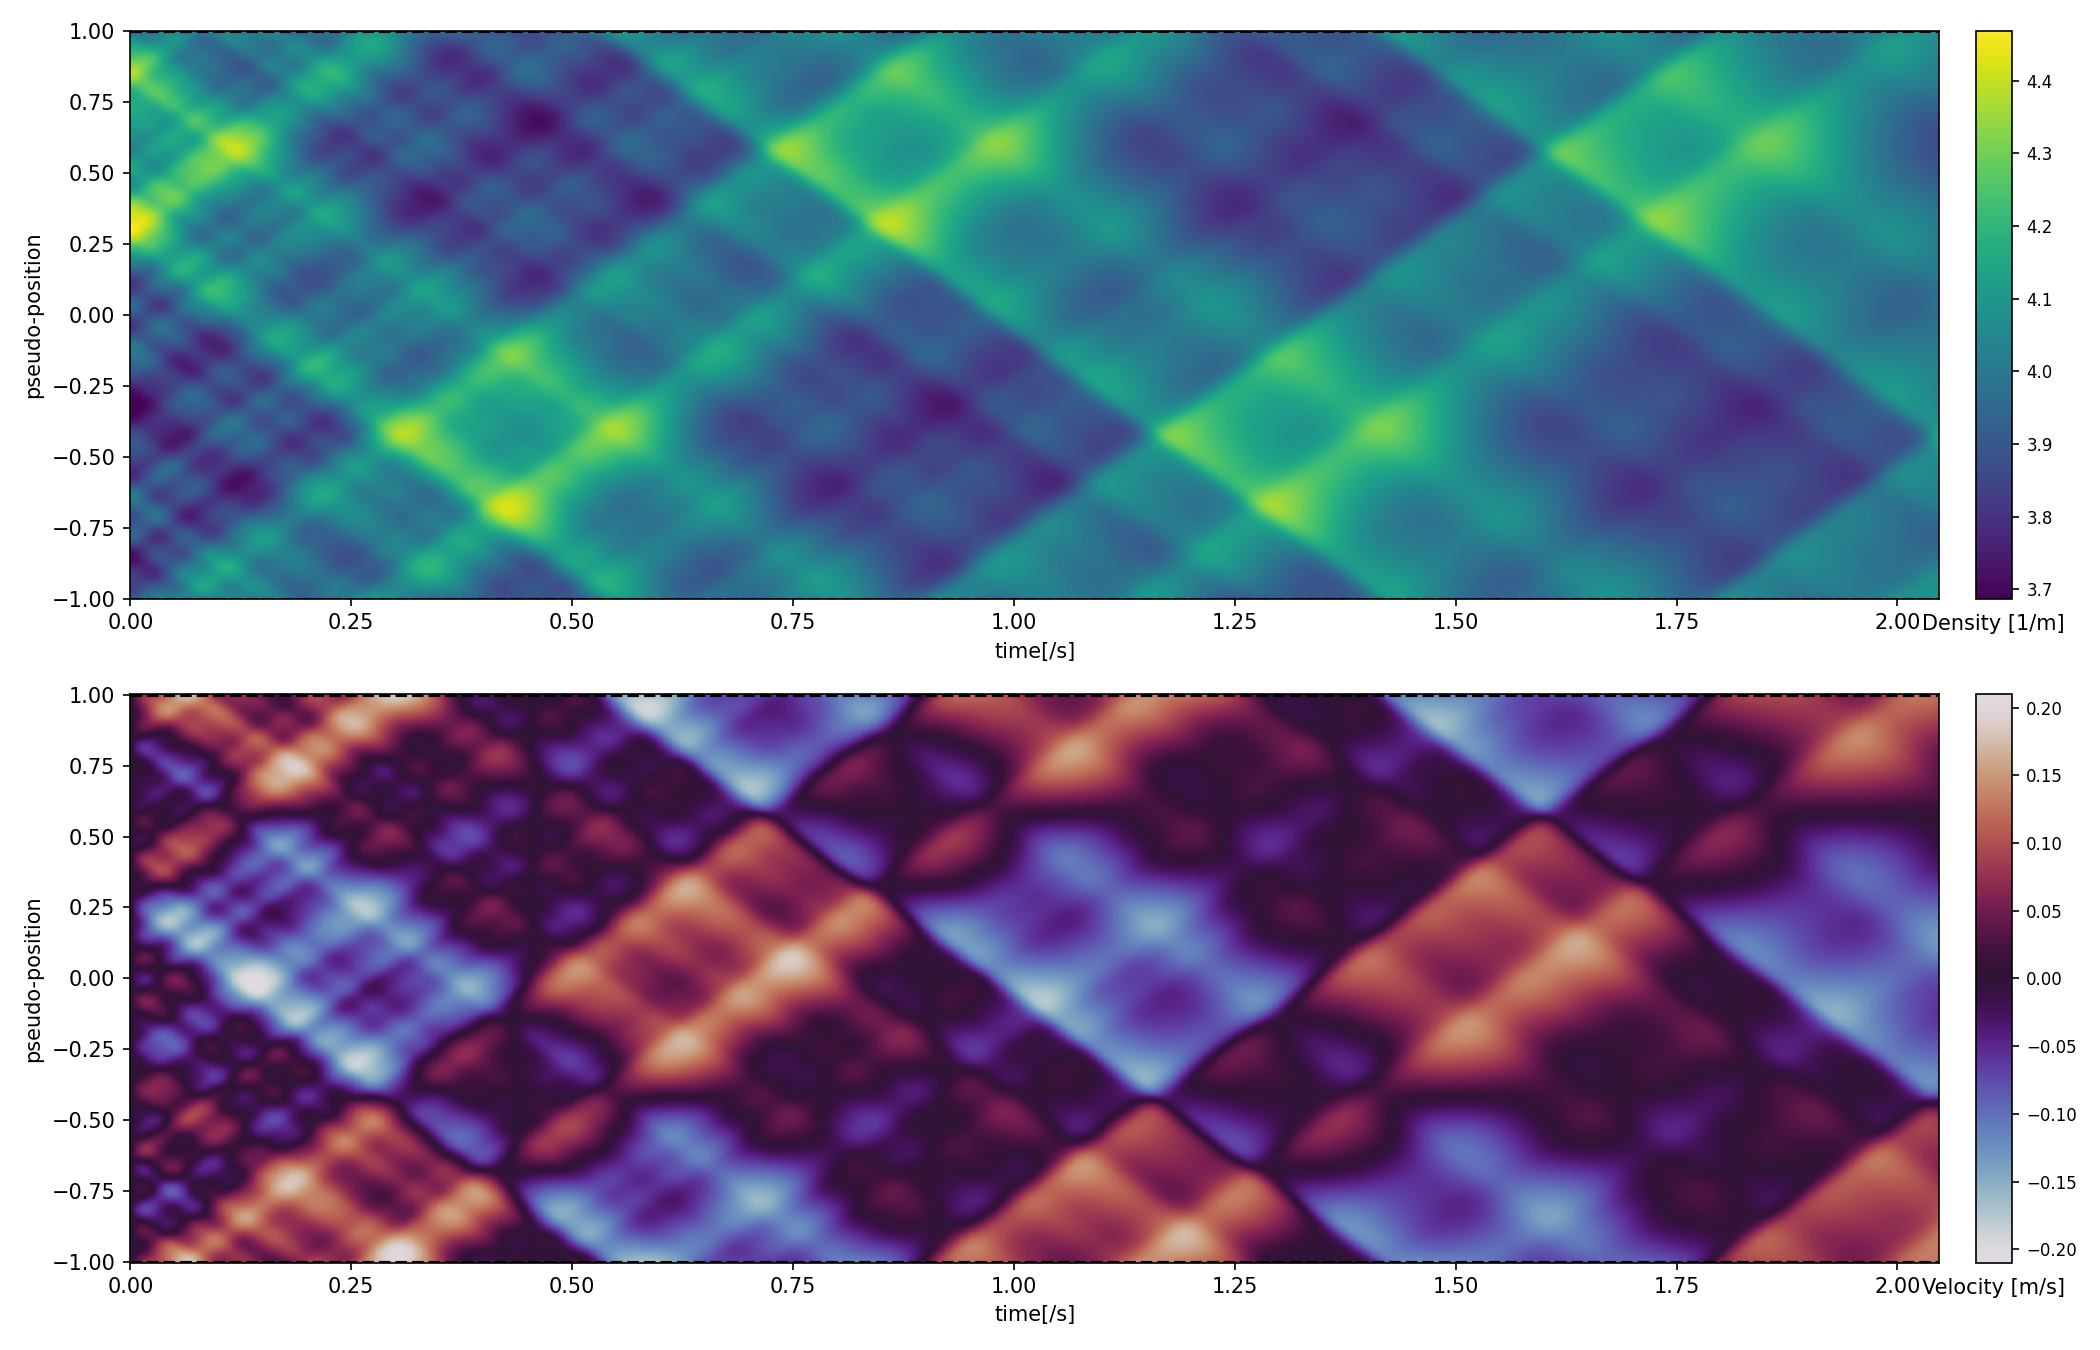

In [101]:
# plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [])
# plotDistorted(simulationStates, minDomain, maxDomain, dt)
# scatterPlotAll(simulationStates, minDomain, maxDomain, dt)
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

In [20]:

def regularPlot(simulationStates, minDomain, maxDomain, dt, nx = 512, ny = 2048):
    timeArray = torch.arange(simulationStates.shape[0])[:,None].repeat(1,simulationStates.shape[2]) * dt
    positionArray = simulationStates[:,0]
    xys = torch.vstack((timeArray.flatten(), positionArray.flatten())).mT  


    # interpVelocity = LinearNDInterpolator(xys, simulationStates[:,1].flatten())
    # interpDensity = LinearNDInterpolator(xys, simulationStates[:,2].flatten())
    interpVelocity = NearestNDInterpolator(xys, simulationStates[:,1].flatten())
    interpDensity = NearestNDInterpolator(xys, simulationStates[:,2].flatten())

    X = torch.linspace(torch.min(timeArray), torch.max(timeArray), ny)
    Y = torch.linspace(torch.min(positionArray), torch.max(positionArray), nx)
    X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
    # Z = interp(X, Y)

    fig, axis = plt.subplots(2, 1, figsize=(14,9), sharex = False, sharey = False, squeeze = False)


    im = axis[0,0].pcolormesh(X,Y,interpDensity(X,Y), cmap = 'viridis', vmin = torch.min(torch.abs(simulationStates[:,2])),vmax = torch.max(torch.abs(simulationStates[:,2])))
    # im = axis[0,0].imshow(simulationStates[:,2].mT, extent = [0,dt * simulationStates.shape[0], maxDomain,minDomain])
    axis[0,0].set_aspect('auto')
    axis[0,0].set_xlabel('time[/s]')
    axis[0,0].set_ylabel('pseudo-position')
    ax1_divider = make_axes_locatable(axis[0,0])
    cax1 = ax1_divider.append_axes("right", size="2%", pad="2%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    axis[0,0].axhline(minDomain, color = 'black', ls = '--')
    axis[0,0].axhline(maxDomain, color = 'black', ls = '--')
    cb1.ax.set_xlabel('Density [1/m]')

    im = axis[1,0].pcolormesh(X,Y,interpVelocity(X,Y), cmap = 'twilight', vmin = -torch.max(torch.abs(simulationStates[:,1])),vmax = torch.max(torch.abs(simulationStates[:,1])))
    # im = axis[1,0].imshow(simulationStates[:,1].mT, extent = [0,dt * simulationStates.shape[0], maxDomain,minDomain], cmap = 'RdBu', vmin = -torch.max(torch.abs(simulationStates[:,1])),vmax = torch.max(torch.abs(simulationStates[:,1])))
    axis[1,0].set_aspect('auto')
    axis[1,0].set_xlabel('time[/s]')
    axis[1,0].set_ylabel('pseudo-position')
    ax1_divider = make_axes_locatable(axis[1,0])
    cax1 = ax1_divider.append_axes("right", size="2%", pad="2%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='vertical')
    cb1.ax.tick_params(labelsize=8) 
    axis[1,0].axhline(minDomain, color = 'black', ls = '--')
    axis[1,0].axhline(maxDomain, color = 'black', ls = '--')
    cb1.ax.set_xlabel('Velocity [m/s]')

    fig.tight_layout()

